In [1]:
import os
import sys
import time
import datetime
import re
import multiprocessing
import ast

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
rc={'lines.linewidth': 2, 'axes.labelsize': 14, 'axes.titlesize': 14}

sns.set(rc=rc)

from scipy import ndimage as ndi
import scipy as scp
import pandas as pd

import matplotlib.animation as anm
from IPython.display import HTML

from skimage.external.tifffile import TiffWriter

from PIL import Image

import skimage.filters
import skimage.io
import skimage.morphology
import skimage.feature
import skimage.exposure

from skimage import data, color
from skimage.transform import hough_circle, hough_circle_peaks
from skimage.draw import circle_perimeter
from skimage.util import img_as_ubyte

from bokeh.plotting import figure
from bokeh.io import output_notebook, show
from bokeh import palettes, transform

rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 24, 
      'xtick.labelsize': 18, 
      'ytick.labelsize': 18, 
      'legend.fontsize': 18,
      'axes.facecolor': 'fbfbfc'}
sns.set_context('talk', rc=rc)

%matplotlib inline
output_notebook()

# you need to populate image lists from the two folders

# file_temp = "/mnt/disks/movie-181208/180827_1/{}/img_{:09d}_{}_000.tif"

Loading BokehJS ...

In [2]:
# Channel information for IX81 inverted microscope
all_channel_inds = [str(xx) for xx in range(6)]
all_channel_names = ['Brightfield', 'GFP', 'YFP', 'mScarlet', 'unk', 'sfCFP']
all_channel_dict = dict(zip(all_channel_inds, all_channel_names))

def img_metadata_dict(img):
    '''Read metadata into dictionary from the TIFF metadata. 
    
        This function uses string replacements to read dictionary key-value pairs.
    
    '''
    metadata_key = 50839
    metadata_str = img.tag[metadata_key].decode('utf-8').replace("\x00","")
    splits = re.split(",",metadata_str)
    metadata_keys = []
    metadata_vals = []
    for split_x in splits:
        hits = re.findall(r"(?<=\").*?(?=\")", split_x)
        if len(hits) == 3:
            key, _, val = [hit.replace("'","").strip() for hit in hits]
            metadata_keys.append(key)
            metadata_vals.append(val)
    return dict(zip(metadata_keys, metadata_vals))

def img_metadata_dict_full(img):
    '''Read metadata into dictionary from the TIFF metadata. 
    
        After some cleanup, this function reads the metadata string directly as a dictionary definition.
    '''
    metadata_key = 50839
    metadata_str = img.tag[metadata_key].decode('utf-8').replace("\x00","")
    in_str = metadata_str[9:].replace('\n','').replace('\s*','').replace('null','None').replace('false','True')
    out_dict = ast.literal_eval(in_str)
    return out_dict

def img_metadata(img):
    '''Read creation time from the TIFF metadata in seconds from Epoch'''
    metadata = img_metadata_dict(img)
    time_tuple = time.strptime(metadata['Time'],r"%Y-%m-%d %H:%M:%S %z")
    return time.mktime(time_tuple), metadata["Channel"]

def fn_metadata(fn):
    '''Wrapper for reading creation time from an image filename'''
    with Image.open(fn) as img:
        out = img_metadata(img)
    return out

def fn_metadata_full(fn):
    '''Wrapper for reading full metadata dictionary from a filename'''
    with Image.open(fn) as img:
        out = img_metadata_dict_full(img)
    return out

def get_time_vector_from_fn(fn):
    time_dict = dict(zip(channel,len(channel)*[]))
    with Image.open(fn) as img:
        try:
            while 1:
                ct, ch = img_metadata(img)
                time_dict[chan_dict[ch]].append(ct)
                img.seek(img.tell()+1)
        except EOFError:
            pass
        except ValueError:
            pass
        except SyntaxError:
            pass
    return time_dict

def get_data_from_frame(img):
    ct, ch = img_metadata(img)
    im_arr = np.array(list(img.getdata()),dtype=np.uint16).reshape(img.size[::-1])
    return ct, ch, im_arr

def get_movie_from_img(img):
    img_dict = dict(zip(channel,len(channel)*[]))
    time_dict = dict(zip(channel,len(channel)*[]))
    try:
        img.seek(0)
        while 1:
            ct, ch, im_arr = get_data_from_frame(img)
            ch = chan_dict[ch]
            img_dict[ch].append(im_arr)
            time_dict[ch].append(ct)
            img.seek(img.tell()+1)
    except EOFError:
        pass
    except ValueError:
        pass
    except SyntaxError:
        pass
    for key in img_dict:
        h, w = im_arr.shape
        img_dict[key] = np.vstack([x.reshape((1, h, w, 1)) for x in img_dict[key]])
    return img_dict, time_dict

def read_img(fn):
    with Image.open(fn) as img:
        return get_movie_from_img(img)
        
def concat_img_files(fn_list, fn_out):
    keep_keys = ['Channel', 'Time', 'PositionName']
    metadata = dict(zip(keep_keys, keep_keys))
    i = 0
    #ct = datetime.datetime.fromtimestamp(ctime(fn))
    with TiffWriter(fn_out, bigtiff=True) as tif:
        for fn in fn_list:
            eof_flag = True
            print("Writing ", fn)
            with Image.open(fn) as img:
                while eof_flag:
                    _, _, im_arr = get_data_from_frame(img)
                    img_md = img_metadata_dict(img)
                    for k in keep_keys:
                        metadata[k] = img_md[k]
                    metadata['Frame'] = int(os.path.basename(fn).split("_")[1])
                    h, w = im_arr.shape
                    tif.save(im_arr, metadata=metadata.copy())
                    try:
                        i += 1
                        img.seek(img.tell()+1)
                    except:
                        eof_flag = False
        
def convert_img_file(fn, fn_out):
    dirname = os.path.dirname(fn)
    fn_out = os.path.join(dirname, fn_out)
    ct = datetime.datetime.fromtimestamp(ctime(fn))
    eof_flag = True
    with Image.open(fn) as img:
        with TiffWriter(fn_out, bigtiff=True) as tif:
            while eof_flag:
                _, _, im_arr = get_data_from_frame(img)
                metadata = img_metadata_dict(img)
                tif.save(im_arr, datetime=ct, metadata=metadata)
                try:
                    img.seek(img.tell()+1)
                except:
                    eof_flag = False
    
def process_file(fn, skip=0):
    with Image.open(fn) as img:
        eof_flag = True
        column_names = ('time', 'colony', 'sfcfp', 'mscarlet', 'col_size', 'sfcfp_bg', 'mscarlet_bg')
        df = pd.DataFrame(columns = column_names)
        try:
            while eof_flag:
                acq_dict = {}
                for i in range(3):
                    ct, ch, im_arr = get_data_from_frame(img)
#                     ch = chan_dict[ch]
                    acq_dict[ch] = (ct, im_arr)
                    try:
                        img.seek(img.tell()+1)
                    except EOFError:
                        eof_flag = False
                rfps, cfps, sizes, num, cfp_bg, rfp_bg = get_fluors(acq_dict['3'][1], acq_dict['5'][1], acq_dict['0'][1])
                for col_i in range(num):
                    df_dict = dict(zip(column_names, [[ct], [col_i], [cfps[col_i]], [rfps[col_i]], [sizes[col_i]], [cfp_bg], [rfp_bg]]))
                    df = df.append(pd.DataFrame(df_dict), ignore_index=True)
                try:
                    img.seek(img.tell()+3*skip)
                except EOFError:
                    eof_flag = False
        except EOFError:
            pass
        except ValueError:
            pass
        except SyntaxError:
            pass
        df.to_csv(fn+".csv")
    return df

    
def process_file_skimage(fn):
    time_vec = get_time_vector_from_fn(fn)['"Brightfield"']
    im = skimage.io.imread(fn)
    column_names = ('time', 'colony', 'sfcfp', 'mscarlet', 'col_size', 'sfcfp_bg', 'mscarlet_bg')
    df = pd.DataFrame(columns = column_names)
    try:
        while eof_flag:
            acq_dict = {}
            for i in range(3):
                ct, ch, im_arr = get_data_from_frame(img)
                acq_dict[ch] = (ct, im_arr)
                try:
                    img.seek(img.tell()+1)
                except EOFError:
                    eof_flag = False
            rfps, cfps, sizes, num, cfp_bg, rfp_bg = get_fluors(acq_dict['3'][1], acq_dict['5'][1], acq_dict['0'][1])
            for col_i in range(num):
                df_dict = dict(zip(column_names, [[ct], [col_i], [cfps[col_i]], [rfps[col_i]], [sizes[col_i]], [cfp_bg], [rfp_bg]]))
                df = df.append(pd.DataFrame(df_dict), ignore_index=True)
    except EOFError:
        pass
    except ValueError:
        pass
    except SyntaxError:
        pass
    except KeyError:
        pass
    df.to_csv(fn+".csv")
    return df

def ctime(fname):
    '''Read creation time from the TIFF metadata in seconds from Epoch'''
    metadata_key = 50839
    with Image.open(fname) as img:
        metadata_str = img.tag_v2[50839].decode('utf-8').replace("\x00","")
    splits = re.split(",",metadata_str)
    metadata_keys = []
    metadata_vals = []
    for split_x in splits:
        hits = re.findall(r"(?<=\").*?(?=\")", split_x)
        if len(hits) == 3:
            key, _, val = [hit.replace("'","").strip() for hit in hits]
            metadata_keys.append(key)
            metadata_vals.append(val)
    metadata = dict(zip(metadata_keys, metadata_vals))

    time_tuple = time.strptime(metadata['Time'][:-6],r"%Y-%m-%d %H:%M:%S")
    return time.mktime(time_tuple)

def crop(img):
    w, h = img.shape
    if w > 1000:
        x1, x2, y1, y2 = np.array((80, 650 ,20, 550))*2
    else:
        x1, x2, y1, y2 = np.array((80, 650 ,20, 550))
    return(img[y1:y2,x1:x2])

def uncrop(img):
    w, h = img.shape
    if w > 800:
        out_img = np.zeros((512*2, 672*2))
        x1, x2, y1, y2 = np.array((80, 650 ,20, 550))*2
    else:
        out_img = np.zeros((512, 672))
        x1, x2, y1, y2 = np.array((80, 650 ,20, 550))
    out_img[y1:y2,x1:x2] = img
    return(out_img)

def label_image(im_arr):
    im_arr = im_arr.astype(np.float32).astype(np.uint16) / 65535
    w, h = im_arr.shape

    # Convert the uneven image to floating point
    im_float = im_arr
    # Smooth to reduce noise
    g_radius = 5
    im_smooth = skimage.filters.gaussian(im_float, g_radius)
    im_bgsub = im_float - im_smooth

    # Perform the median filter
    selem = skimage.morphology.square(4)
    im_bgsub = skimage.filters.median(im_bgsub, selem) / 4096.0
    
    # Adjust exposure
    im_adj = skimage.exposure.equalize_adapthist(im_bgsub)

    # Edge detection
    im_edge = skimage.filters.sobel(im_adj)
    im_edge = skimage.exposure.equalize_adapthist(im_adj)

    # Remove small objects and fill holes
    if np.all(im_edge == im_edge[0,0]) or np.any(np.isnan(im_edge)):
        return np.zeros((w,h)), 1
    thresh = skimage.filters.threshold_otsu(im_edge)
    selem = skimage.morphology.square(2)
    im_bw = skimage.morphology.binary_dilation(im_edge > thresh, selem)
    selem = skimage.morphology.square(12)
    im_bw = skimage.morphology.binary_closing(im_bw, selem)
    
    im_bw = skimage.morphology.remove_small_objects(im_bw, min_size=10)
    im_labeled, num = skimage.morphology.label(im_bw, return_num=True)
    return im_labeled, num

def get_fluors(bfi, rfp, gfp):
    im_labeled, num = label_image_2(bfi)
    num  = im_labeled.max()
#     rfp, gfp = [crop(x) for x in [rfp, gfp]]
    gfps = [np.mean(gfp[im_labeled == x]) for x in np.arange(1,num+1)]
    rfps = [np.mean(rfp[im_labeled == x]) for x in np.arange(1,num+1)]
    gfp_bg = np.mean(gfp[im_labeled == 0])
    rfp_bg = np.mean(rfp[im_labeled == 0])
    sizes = [np.sum(im_labeled == x) for x in np.arange(1,num+1)]
    return rfps, gfps, sizes, num, gfp_bg, rfp_bg

def read_tiff_file(fn, skip=0):
    print("Begin " + fn)
    df = process_file(fn, skip=skip)
    df.to_csv(fn+".csv", index=False)
    print("Finished " + fn)

def par_worker(fn_list, skip=1):
    for fn in fn_list:
        read_tiff_file(fn, skip=skip)
    

In [3]:
import pandas as pd
super_dir = '/mnt/disks/timelapse-movies/190108/data'
exp_dirs = [os.path.join(super_dir, xx) for xx in os.listdir(super_dir)]
pos_dirs = [os.path.join(exp_dir, xx) for exp_dir in exp_dirs for xx in os.listdir(exp_dir) if 'Pos' in xx]
img_files = []
pos_vec = []
frame_vec = []
channel_vec = []
time_vec = []
for pos_dir in pos_dirs:
    tmp_dir, pos_str = pos_dir.split('Pos')
    pos_int = np.int(pos_str)
    tmp_img_files = [xx for xx in os.listdir(pos_dir) if '.tif' in xx]
    img_files.extend([os.path.join(pos_dir, xx) for xx in tmp_img_files])
    time_vec.extend([ctime(os.path.join(pos_dir, xx)) for xx in tmp_img_files])
    pos_vec.extend(len(tmp_img_files)*[pos_int])
    frame_vec.extend([np.int(xx[4:13]) for xx in tmp_img_files])
    channel_vec.extend([np.int(xx[14:15]) for xx in tmp_img_files])

files_df = pd.DataFrame(dict(zip(['pos','frame','channel', 'fn', 'time'], [pos_vec, frame_vec, channel_vec, img_files, time_vec])))
t_min = files_df.time.min()
files_df.loc[:,'time'] = files_df.loc[:,'time'] - t_min


In [4]:
# sorted_fdf = files_df.sort_values(by=['frame', 'pos', 'channel'])
# print(sorted_fdf)

# quickly just sum all of the fluorescence channels

def par_worker(fdf_sub, fn_out):
    df_index = fdf_sub.index
    n_rows, _ = fdf_sub.shape
    columns = ['pos', 'frame', 'channel', 'sum', 'time']
    n_col = len(columns)
    out_df = pd.DataFrame(np.zeros((n_rows, n_col),dtype=np.int), columns=columns, index=df_index)
    for i in df_index:
        pos, frame, channel, fn, time = fdf_sub.loc[i,:]
        im = skimage.io.imread(fn)
        img_sum = im.sum().sum()
        out_df.loc[i,:] = np.array([pos, frame, channel, img_sum, time], dtype=np.int)
    out_df.to_csv(fn_out)

fdf_fluor = files_df.loc[files_df.channel > 0,:]
fn_outs = ["worker_outputs/par_output_{}.csv".format(xx) for xx in range(4)]

jobs = []
for i in [0,1,2,3]:
    p = multiprocessing.Process(target=par_worker, 
                                args=(fdf_fluor.iloc[i::4,:], fn_outs[i]))
    jobs.append(p)
    p.start()
for j in jobs:
    j.join()
print("Done!")


Done!


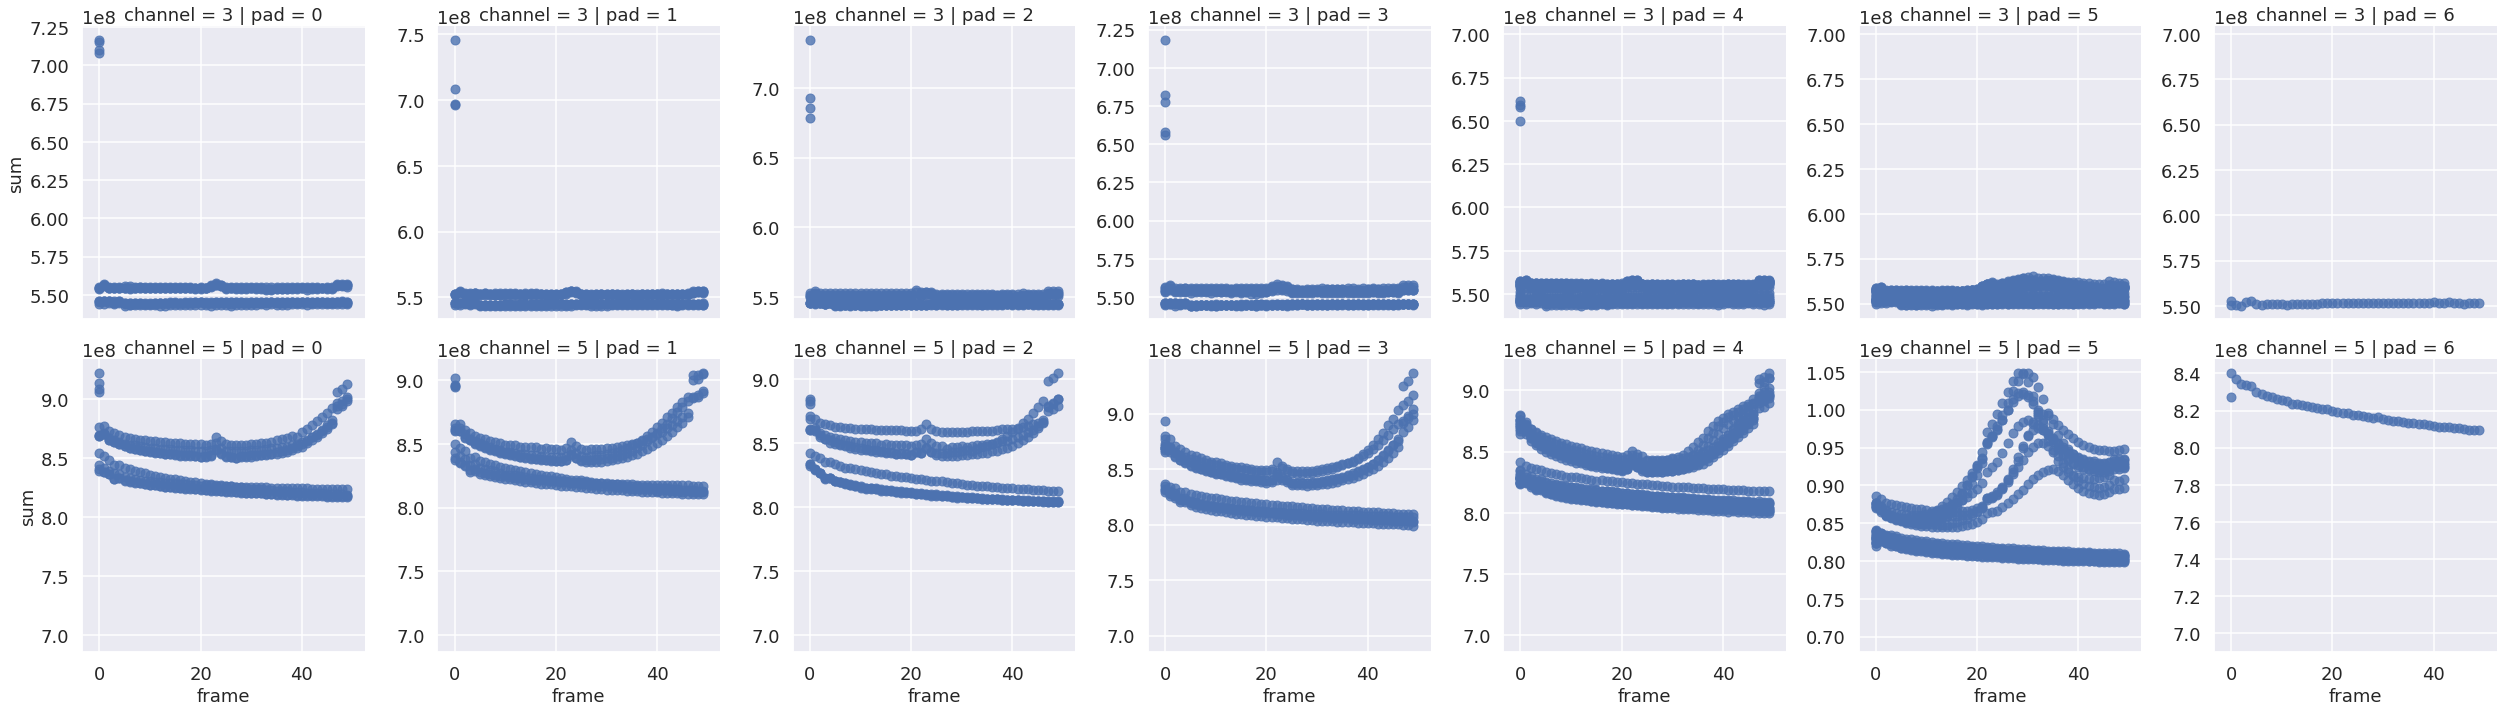

In [13]:
all_data = pd.concat([pd.read_csv(fn, index_col=0) for fn in fn_outs])
def pad_fn(pos):
    pad_limits = [4, 8, 12, 17, 27,n_pos]    
    # using pad_limits, assign pad labels
    pad_ind = 0
    for lim in pad_limits:
        if pos >= lim:
            pad_ind += 1
    return pad_ind

pad_vec = [pad_fn(xx) for xx in all_data.pos.values]
pad_series = pd.Series(pad_vec, index=all_data.index)

df = all_data.assign(pad=pad_series)
g = sns.lmplot(data=df, x='frame', y='sum', row='channel', fit_reg=False, sharey=False, col='pad')
# g.axes[0,0].set_title('RFP Strain 0')
# g.axes[0,1].set_title('RFP Strain 1')
# g.axes[0,2].set_title('RFP Strain 2')
# g.axes[1,0].set_title('CFP Strain 0')
# g.axes[1,1].set_title('CFP Strain 1')
# g.axes[1,2].set_title('CFP Strain 2')

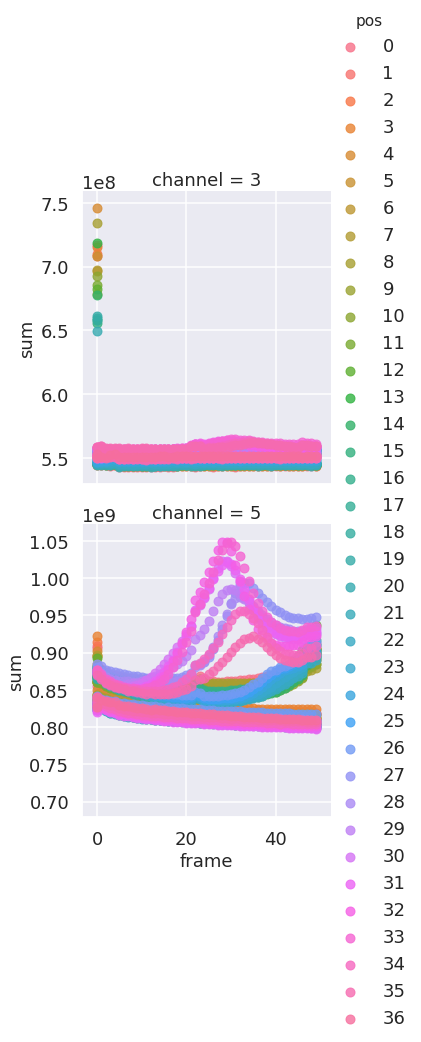

In [15]:
sub_df = df.loc[df.pad ==5,:]
g = sns.lmplot(data=df, x='frame', y='sum', row='channel', fit_reg=False, sharey=False, hue='pos')

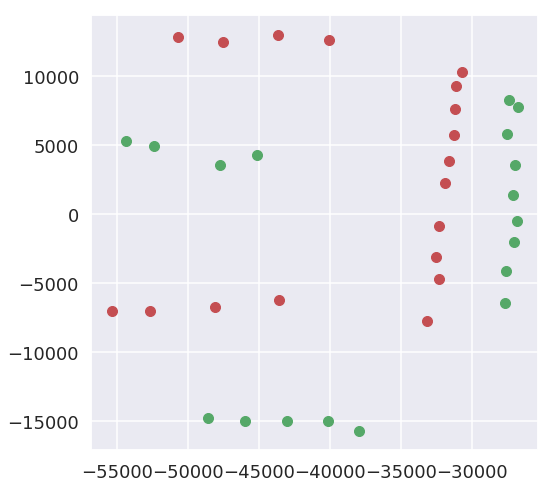

In [10]:
# pad limits interpreted from the plot below
pad_limits = [4, 8, 12, 17, 27,n_pos]
# Extract movie metadata
all_metadata = fn_metadata_full(img_files[0])
summ_dict = all_metadata['Summary']
chan_ind = summ_dict['ChNames']
chan_int = [int(xx) for xx in chan_ind]
n_chan = len(chan_ind)
chan_int_dict = dict(zip(chan_int, np.arange(n_chan)))
chan_name = [all_channel_dict[xx] for xx in chan_ind]
n_pos = summ_dict['Positions']
n_frames = summ_dict['Frames']
im_width = summ_dict['Width']
im_height = summ_dict['Height']

# Cor_pos_df is corrected position DF. In this notebook, correcting the position is not
# necessary as there are only two imaging positions per pad. DF also includes inducer info
# 0, 1, 2 for inducers blank, C, R; respectively
cor_pos_df = pd.DataFrame(np.empty((n_pos,6)),
                          columns=['x','y','label', 'pos', 'pad', 'strain'])
for p_i in np.arange(n_pos):
    x, y = summ_dict['InitialPositionList'][p_i]['DeviceCoordinatesUm']['XYStage']
    label = summ_dict['InitialPositionList'][p_i]['Label']
    cor_pos_df.loc[p_i,['x', 'y', 'label', 'pos']] = [x, y, label, p_i]

# using pad_limits, assign pad labels
pad_ind = 0
for pos in np.arange(n_pos):
    if pos >= pad_limits[pad_ind]:
        pad_ind += 1
    cor_pos_df.loc[pos,['pad']] = pad_ind

    
def dist_f(pad_ind):
    '''
    Calculates distance between colonies for input pad index
    '''
    pos_arr = cor_pos_df.loc[cor_pos_df.pad == 3, ['x', 'y']].values
    dist = np.sqrt(np.sum(np.power(np.diff(pos_arr, axis=0),2)))
    return dist
    
plt.figure(figsize=(8,8))
for p_i in np.arange(n_pos):
    colors = 'rg'
    point_color = colors[np.int(np.mod(cor_pos_df.loc[p_i,"pad"],2))]
    plt.plot(np.float(cor_pos_df.x[p_i]), 
             -np.float(cor_pos_df.y[p_i]), 
             '.', 
             label=cor_pos_df.label[p_i],
             ms=20,
             c=point_color)
# plt.legend()

In [ ]:
# Scrape metadata

def make_tdf():
    template = "/mnt/disks/timelapse-movies/180831/20180831_1/{}/img_{:09d}_0_000.tif"
    i = 0
    t_skip = 1
    t_points = np.arange(0,n_frames,t_skip)
    t_len = len(t_points)
    p_skip = 1
    p_points = np.arange(0,n_pos,p_skip)
    p_len = len(p_points)
    t_df = pd.DataFrame(np.empty((n_frames*n_pos,3)), columns=['frame', 'pos', 'time'])
    for p_i in p_points:
        for t_i in t_points:
            fn = template.format(cor_pos_df.loc[p_i,'label'], t_i)
            t_df.loc[i,:] = np.array([t_i, p_i, ctime(fn)])
            i += 1
    t_df.to_csv('{}_time.csv'.format(nb_prefix), index=False)


make_tdf()
t_df = pd.read_csv('{}_time.csv'.format(nb_prefix))

In [ ]:
# Make a tiff image stack without a mask channel
def make_movie(fn_out, t_skip=5, p_skip=1, files_df=files_df):
    # I don't think this works but keep a metadata dictionary to store useful metatdata in 
    # the output video
    keep_keys = ['Channel', 'Time', 'PositionName']
    metadata = dict(zip(keep_keys, keep_keys))
    # Set indices
    i = 0
    t_points = np.arange(0,n_frames,t_skip)
    t_len = len(t_points)
    p_points = np.arange(0,n_pos,p_skip)
    p_len = len(p_points)
    im_out = np.zeros((t_len,p_len,n_chan,im_height,im_width,1), dtype=np.uint16)
    # Write movie to file
    with TiffWriter(fn_out, imagej=True, append=False) as tif:
        for tp in t_points:
            for pp in p_points:
                # position label is used to complete filename
                # strain is used to determine which fluorescence channel to use for segmentation
                pos_str = cor_pos_df.loc[pp, 'label']
                for cp in chan_int:
                    fn = file_temp.format(pos_str, tp, cp)
                    eof_flag = True
                    print("Writing ", fn)
                    with Image.open(fn) as img:
                        while eof_flag:
                            _, _, im_arr = get_data_from_frame(img)
                            if im_arr.shape[0] > 2000:
                                im_arr = np.round(skimage.transform.downscale_local_mean(im_arr, (2,2)))
                            im_arr = im_arr.astype(np.float32).astype(np.uint16)
                            img_md = img_metadata_dict_full(img)
                            for k in keep_keys:
                                metadata[k] = img_md[k]
                            h, w = im_arr.shape
                            im_out[tp//t_skip, pp//p_skip, chan_int_dict[cp], :, :, 0] = im_arr
                            try:
                                i += 1
                                img.seek(img.tell()+1)
                            except:
                                eof_flag = False
        tif.save(im_out, metadata=metadata.copy())

# make_movie('fullmovie_nomask.tif')

In [ ]:
# Make a tiff image stack with a mask channel
def make_movie(fn_out, t_skip=10, p_skip=1, n_pos=n_pos,n_frames=n_frames):
    # I don't think this works but keep a metadata dictionary to store useful metatdata in 
    # the output video
    keep_keys = ['Channel', 'Time', 'PositionName']
    metadata = dict(zip(keep_keys, keep_keys))
    # Set indices
    i = 0
    t_points = np.arange(0,n_frames,t_skip)
    t_len = len(t_points)
    p_points = np.arange(0,n_pos,p_skip)
    p_len = len(p_points)
    im_out = np.zeros((t_len,p_len,n_chan+1,im_height,im_width,1), dtype=np.uint16)
    # Write movie to file
    with TiffWriter(fn_out, imagej=True, append=False) as tif:
        for tp in t_points:
            for pp in p_points:
                # position label is used to complete filename
                # strain is used to determine which fluorescence channel to use for segmentation
                pos_str, strain = cor_pos_df.loc[pp, ['label', 'strain']]
                if strain == 'pCR':
                    segment_channel = 1 # gfp channel
                else:
                    segment_channel = 2 # rfp channel
                for cp in chan_int:
                    pos_str = cor_pos_df.loc[pp, 'label']
                    fn = file_temp.format(pos_str, tp, cp)
                    eof_flag = True
                    print("Writing ", fn)
                    with Image.open(fn) as img:
                        while eof_flag:
                            # Get image array
                            _, _, im_arr = get_data_from_frame(img)
                            # Label image
                            if cp == segment_channel:
                                im_lab, col_num = label_image(im_arr)
                                im_out[tp//t_skip, pp//p_skip, n_chan, :, :, 0] = im_lab.astype(np.uint16)
                            # Downscale if image width is more than 2000 pixels
                            if im_arr.shape[0] > 2000:
                                im_arr = np.round(skimage.transform.downscale_local_mean(im_arr, (2,2)))
                            im_arr = im_arr.astype(np.float32).astype(np.uint16)
                            # I'm not sure this works but keep image metadata for the current frame
                            img_md = img_metadata_dict_full(img)
                            for k in keep_keys:
                                metadata[k] = img_md[k]
                            h, w = im_arr.shape
                            im_out[tp//t_skip, pp//p_skip, chan_int_dict[cp], :, :, 0] = im_arr
                            try:
                                i += 1
                                img.seek(img.tell()+1)
                            except:
                                eof_flag = False
        tif.save(im_out, metadata=metadata.copy())

# make_movie('fullmovie_mask.tif', n_frames=80, n_pos=6)

In [ ]:
import matplotlib.animation as anm
from IPython.display import HTML

# img = skimage.io.imread(f_names[2])
def write_movie(img, skip=10, pos=3):
    plt.close('all')
    
    t_points, s, c, h, w = img.shape
    t_vec = np.arange(0, t_points, skip)
    frames = len(t_vec)
    #t_list = list(t_vec[-1::-1]) + [-1]
    
    t_list = np.arange(t_points)
    
    blank_array = np.zeros([h, w])
    fig, axs = plt.subplots(2,2, figsize=(10,8))
    im_list = [0,0,0,0]
    
    # initialize plots
    titles = ['bf', 'gfp', 'mscarlet', 'lab']
    vmaxs = [2.8e4  , 1e4, 1e4, 1]
    vmins = [1e4, 1e3, 1e3, 0]
    for i in np.arange(3):
        ax = axs[i//2, np.mod(i,2)]
        indxs = [i]
        vmax = vmaxs[i]
        vmin = vmins[i]
        im = ax.imshow(blank_array, animated=True, vmax=vmax, vmin=vmin, interpolation='none')
        cbar = fig.colorbar(im, ax=ax, ticks=[vmin, vmax])
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(titles[i])
        im_list[i] = im
    
    fig.tight_layout()
    
    # animation function.  This is called sequentially
    frame_arr = np.zeros((h,w))
    def animate(i):
        # Plot 
        for j in np.arange(3):
            ax = axs[j//2, np.mod(j,2)]
            frame_arr = img[i*skip,pos,j,:,:]#.sum(axis=0)
            im_list[j].set_array(frame_arr)

    # call the animator.  blit=True means only re-draw the parts that have changed.
#     writer = anm.HTMLWriter()
    anim = anm.FuncAnimation(fig, animate, interval=100, frames=frames)


    # Set up formatting for the movie files
    #Writer = anm.writers['ffmpeg_file']
    #writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=900, extra_args=['-vcodec', 'libx264'])

    # save the animation as an mp4.  This requires ffmpeg or mencoder to be
    # installed.  The extra_args ensure that the x264 codec is used, so that
    # the video can be embedded in html5.  You may need to adjust this for
    # your system: for more information, see
    # http://matplotlib.sourceforge.net/api/animation_api.html
    #anim.save('animation_{}.mp4'.format(fn), extra_args=['-vcodec', 'libx264'], dpi=50, writer=writer)
    #plt.close('all')


    #anim.save('animation_{}.mp4'.format(fn), writer=writer)
    plt.close('all')
    return anim
    #HTML(anim.to_html5_video())
    

# with skimage.external.tifffile.TiffFile('180320_fullmovie_masktry.tif') as img:
#     im_all = img.asarray()
anim = write_movie(im_all, skip=1, pos=7)
HTML(anim.to_jshtml())

In [ ]:
anim.to_html5_video?

In [ ]:
t, s, c, h, w = im_all.shape
im_out = np.zeros((t,3,h,5*w), dtype=np.float32)

# First set up the figure, the axis, and the plot element we want to animate
blank_array = np.zeros([h, 5*w, 3])
gray_array = np.ones([h, w, 3])
red_array = np.zeros([h, w, 3])
red_array[:,:,0] = np.ones([h, w])
red_array[:,:,1] = np.ones([h, w]) * 0
red_array[:,:,2] = np.ones([h, w]) * 0.
cyan_array = np.zeros([h, w, 3])
cyan_array[:,:,0] = np.ones([h, w]) * 0
cyan_array[:,:,1] = np.ones([h, w]) 
cyan_array[:,:,2] = np.ones([h, w])
i=70
# Plot cell densities
min_v = [10e3, 100, 100]
max_v = [30e3, 500, 500]
plt.figure(figsize=(15,3))
# Plot cell densities
frame = np.zeros([h, 5*w, 3])
for c, c_array in enumerate([gray_array, red_array, cyan_array]):
    for p, p_i in enumerate([5,4,3]):
        d_arr = (im_all[i,p_i,c,:,:] - min_v[c]) / (max_v[c] - min_v[c])
#         d_arr[d_arr > 1 ] = 1
#         d_arr[d_arr < 0 ] = 0
        frame[:,(2*w*p):(2*w*(1+p)-w),:] += c_array * np.stack(3*[d_arr], axis=2)
frame[frame > 1 ] = 1
frame[frame < 0 ] = 0
plt.imshow(frame)


In [ ]:
with skimage.external.tifffile.TiffFile('mask_images/mask_44_13.tif') as img:
    im_mask = img.asarray(memmap=True)
_ = plt.imshow(im_mask)

In [ ]:
#
#  Use masks to track fluorescence of microcolonies
#

import matplotlib.animation as anm
from IPython.display import HTML

def par_worker(im_arr, t_df, fn_out):
    img_temp = "mask_images/mask_{:02d}_{:1d}.tif"
    column_names = ('frame','time', 'pos', 'colony', 'sfcfp', 'mscarlet', 'col_size', 'sfcfp_bg', 'mscarlet_bg')
    df = pd.DataFrame(columns=column_names)
    t, s, _, h, w = im_arr.shape
    t_df_piv = t_df.pivot('frame', 'pos', 'time')
    for t_i in range(0,t,1):
        i_frame = t_df.index[t_i]
        for s_i in range(s):
            ct = t_df_piv.loc[i_frame, s_i]
#             im_labeled, num = label_image_2(im_arr[t_i, s_i, 1:2,:,:].sum(axis=0))
            rfps, gfps, sizes, num, gfp_bg, rfp_bg, im_labeled = get_fluors_2(im_arr[t_i,s_i,1,:,:], 
                                                                              im_arr[t_i,s_i,2,:,:])
            img_fn = img_temp.format(i_frame, s_i)
            skimage.io.imsave(img_fn, im_labeled.astype(np.uint8))
#             for col_i in range(num):
#                 df_dict = dict(zip(column_names, [[i_frame],[ct], [s_i], [col_i], [gfps[col_i]], [rfps[col_i]], [sizes[col_i]], [gfp_bg], [rfp_bg]]))
#                 df = df.append(pd.DataFrame(df_dict), ignore_index=True)
#     df.to_csv(fn_out)
    print("wrote ", fn_out)

fn_temp = "processed_part_masktry_{}.csv"
fn_outs = [fn_temp.format(i) for i in range(4)]

jobs = []
for i in [0,1,2,3]:
    p = multiprocessing.Process(target=par_worker, 
                                args=(im_all[i::4,:,:,:,:], 
                                t_df.loc[i::4,:], fn_outs[i]))
    jobs.append(p)
    p.start()
for j in jobs:
    j.join()
print("Done!")

In [ ]:
#
# Simply take means of the full field of view
#

def par_worker(im_arr, t_vec, fn_out):
    column_names = ('time', 'pos', 'sfcfp', 'mscarlet')
    df = pd.DataFrame(columns=column_names)
    t, s, _, h, w = im_arr.shape
    for t_i in range(0,t,1):
        for s_i in range(s):
            ct = t_vec[t_i]
            df_dict = dict(zip(column_names, [[ct], [s_i], [im_arr[t_i,s_i,2,:,:].mean()], [im_arr[t_i,s_i,1,:,:].mean()]]))
            df = df.append(pd.DataFrame(df_dict), ignore_index=True)
    df.to_csv(fn_out)
    print("wrote ", fn_out)

# t_df = pd.read_csv('time.csv', index_col=None)
t_piv = t_df.pivot('frame', 'pos', 'time')
fn_temp = "full_image_part_2_{}.csv"
fn_outs = [fn_temp.format(i) for i in range(4)]

jobs = []
for i in [0,1,2,3]:
    p = multiprocessing.Process(target=par_worker, 
                                args=(im_all[i::4,:,:,:,:], 
                                t_piv.values[i::4,0], fn_outs[i]))
    jobs.append(p)
    p.start()
for j in jobs:
    j.join()
print("Done!")

In [ ]:
temp = 'processed_part_masktry_{}.csv'
column_names = ('time', 'pos', 'colony', 'sfcfp', 'mscarlet', 'col_size', 'sfcfp_bg', 'mscarlet_bg')
df = pd.DataFrame(columns=column_names)
for fn in [temp.format(i) for i in range(4)]:
    df = df.append(pd.read_csv(fn, dtype=np.float), ignore_index=True)

df.head(10)

In [ ]:
temp = 'processed_part_masktry_{}.csv'
column_names = ('time', 'pos', 'colony', 'sfcfp', 'mscarlet', 'col_size', 'sfcfp_bg', 'mscarlet_bg')
df = pd.DataFrame(columns=column_names)
for fn in [temp.format(i) for i in range(4)]:
    df = df.append(pd.read_csv(fn), ignore_index=True)
t_df_piv = t_df.pivot('frame', 'pos', 'time')
for i in np.arange(df.shape[0]):
    i_frame, i_pos = df.loc[i, ["frame","pos"]]
    df.loc[i,'time'] = t_df_piv.loc[np.int(i_frame), i_pos]
df.to_csv('{}_masktry_df_2.csv'.format(nb_prefix))

In [ ]:
# df = pd.read_csv('{}_masktry_df.csv'.format(nb_prefix))
fig, ax = plt.subplots(1,1,figsize=(5,4))
t_min = df.time.min()
ind = (df.pos == 4) & (df.colony>1) & (df.colony<10) # & (np.mod(df.colony,  5)==0 )
df_tmp = df.loc[ind,:]
# ax.plot((df_tmp.time - t_min)/3600, df_tmp.mscarlet,'r.')
# ax.plot((df_tmp.time - t_min)/3600, df_tmp.sfcfp,'c.')
ax.scatter(x=(df_tmp.time - t_min)/3600, 
           y=df_tmp.col_size,
           alpha=1, cmap='viridis')
new_t_vec = np.sort(np.unique(df_tmp.time - t_min))
r_c = (7e-3)/60
for i in np.arange(50,210,50):
    ax.plot(new_t_vec/3600, i*np.exp(new_t_vec*r_c),'k-')
# ax.set_facecolor('gray')
ax.set_ylim([-1e1,200])
ax.set_yticks(np.arange(0,601,200))
ax.set_ylabel('Colony area (pixels)')
ax.set_xlabel('Time (hours)')
ax.set_xticks(np.arange(0,4,1))
fig.tight_layout()
fig.savefig("microscope_cellgrowth.png", dpi=150, transparent=True)
fig.savefig("microscope_cellgrowth.pdf")
# fig, ax = plt.subplots(1,1,figsize=(9,9))
# # ind = (df.time < (6*60*60 + t_min)) & (df.pos == 3)
# # df_tmp = df.loc[ind,:]
to_full_screen = np.log((1024**2)/67057)/r_c
print(to_full_screen / 3600)
print((df.time.max() - t_min)/3600)
print(df.loc[(df.time == t_min)&(df.pos == 4), 'col_size'].sum())
print((df.loc[(df.time == t_min)&(df.pos == 4), 'col_size'].sum())/(1024**2))
# ax.scatter(x=df_tmp.mscarlet, 
#            y=df_tmp.sfcfp,
#            c=df_tmp.time,alpha=0.3, cmap='viridis')
# ax.set_facecolor('gray')
# (df_tmp.time[df_tmp.sfcfp > 200].min() - df_tmp.time[df_tmp.mscarlet > 200].min())


In [ ]:

fig, ax = plt.subplots(1,1,figsize=(10,4))
t_min = df.time.min()
ind = np.isclose(df.pos.astype(np.int), 21)
df_tmp = df.loc[ind,:]
# ax.plot((df_tmp.time - t_min)/3600, df_tmp.mscarlet,'r.')
# ax.plot((df_tmp.time - t_min)/3600, df_tmp.sfcfp,'c.')
ax.scatter(x=(df_tmp.time - t_min)/3600, 
           y=df_tmp.mscarlet,#/ 
#            c=df_tmp.mscarlet,
           alpha=1)#, cmap='viridis')
ax.set_ylim([0,1.5e3])
new_t_vec = np.sort(np.unique(df_tmp.time - t_min))
r_c = (7e-3)/60
# for i in np.arange(50,210,50):
#     ax.plot(new_t_vec/3600, i*np.exp(new_t_vec*r_c),'k-')
# ax.set_facecolor('gray')
# ax.set_ylim([600,800])

# ax.set_yticks(np.arange(0,601,200))
ax.set_ylabel('Colony area (pixels)')
ax.set_xlabel('Time (hours)')
# ax.set_xticks(np.arange(4,8,1))
# ax.set_xlim([0,800])
fig.tight_layout()
# fig.savefig("microscope_cellgrowth.png", dpi=150, transparent=True)
# fig.savefig("microscope_cellgrowth.pdf")
# fig, ax = plt.subplots(1,1,figsize=(9,9))
# # ind = (df.time < (6*60*60 + t_min)) & (df.pos == 3)
# # df_tmp = df.loc[ind,:]
to_full_screen = np.log((1024**2)/67057)/r_c
print(to_full_screen / 3600)
print((df.time.max() - t_min)/3600)
print(df.loc[(df.time == t_min)&(df.pos == 4), 'col_size'].sum())
print((df.loc[(df.time == t_min)&(df.pos == 4), 'col_size'].sum())/(1024**2))
# ax.scatter(x=df_tmp.mscarlet, 
#            y=df_tmp.sfcfp,
#            c=df_tmp.time,alpha=0.3, cmap='viridis')
# ax.set_facecolor('gray')
# (df_tmp.time[df_tmp.sfcfp > 200].min() - df_tmp.time[df_tmp.mscarlet > 200].min())
